# Introduction to ARIMA Models

(Sourced from: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

Forecasting a time series can be broadly divided into two types.

If you use only the previous values of the time series to predict its future values, it is called **Univariate Time Series Forecasting**.

And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called **Multi Variate Time Series Forecasting**.

ARIMA, short for **‘AutoRegressive Integrated Moving Average’**, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. It is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any **‘non-seasonal’** time series that exhibits patterns and is **not a random white noise** can be modeled with ARIMA models.

In [1]:
pip install pmdarima

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.style.use("seaborn-whitegrid")

## 1.) Characterization of ARIMA models

An ARIMA model is characterized by 3 terms: p, d, q

where,

- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

### 1.1) The "d" term

The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a **linear regression model that uses its own lags as predictors**. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

### 1.2) The "p" term

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. 

### 1.3) The "q" term

‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

### 1.4) AR Models

A pure Auto Regressive (AR only) model of order $p$ is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$ Y_{t} = \alpha + \sum_{i=1}^{p} \beta_{i} Y_{t-i} + \epsilon_{t}$

where, 

- $Y_{t-1}$ is the lag1 of the series
- $\beta_1$ is the coefficient of lag1 that the model estimates
- $\alpha$ is the intercept term, also estimated by the model
- $\epsilon_{t}$ is white noise

### 1.5) MA Models

Likewise a pure Moving Average (MA only) model of order $q$ is one where $Y_t$ depends only on the lagged forecast errors.

$ Y_{t} = \alpha + \epsilon_{t} + \sum_{i=1}^{q} \phi_{i} \epsilon_{t-i} $

Notice that each value of $Y_t$ can be thought of as a weighted moving average of the past few forecast errors. However, moving average models should not be confused with the moving average smoothing.

### 1.6) ARIMA = AR + MA

$ Y_{t} = \alpha + \epsilon_{t} + \sum_{i=1}^{p} \beta_{i} Y_{t-i} + \sum_{i=1}^{q} \phi_{i} \epsilon_{t-i} $

The objective, therefore, is to identify the values of p, d and q.


### 1.7) ARMA vs ARIMA

The two models share many similarities. In fact, the AR and MA components are identical, combining a general autoregressive model AR(p) and general moving average model MA(q). AR(p) makes predictions using previous values of the dependent variable. MA(q) makes predictions using the series mean and previous errors.

What sets ARMA and ARIMA apart is differencing. An ARMA model is a stationary model; If your model isn’t stationary, then you can achieve stationarity by taking a series of differences. The “I” in the ARIMA model stands for integrated; It is a measure of how many non-seasonal differences are needed to achieve stationarity. If no differencing is involved in the model, then it becomes simply an ARMA.

A model with a dth difference to fit and ARMA(p,q) model is called an ARIMA process of order (p,d,q). You can select p,d, and q with a wide range of methods, including AIC, BIC, and empirical autocorrelations (Petris, 2009).

Another, similar model is ARIMAX, which is just an ARIMA with additional explanatory variables.

## 2.) Finding d, p, and q

### 2.1) Finding d (order of differencing)

The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

**The right order of differencing is the minimum differencing required to get a near-stationary series** which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing (is **under-differenced**). On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably **over-differenced**.

It may so happen that your series is slightly **under differenced**, that differencing it one more time makes it slightly **over-differenced**.

How to handle this case?

If your series is slightly **under-differenced**, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly **over-differenced**, try adding an additional MA term.

In the event, you can’t really decide between two orders of differencing, then **go with the order that gives the least standard deviation** in the differenced series.

Run a stationarity test, because need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

In [3]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df

,value
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


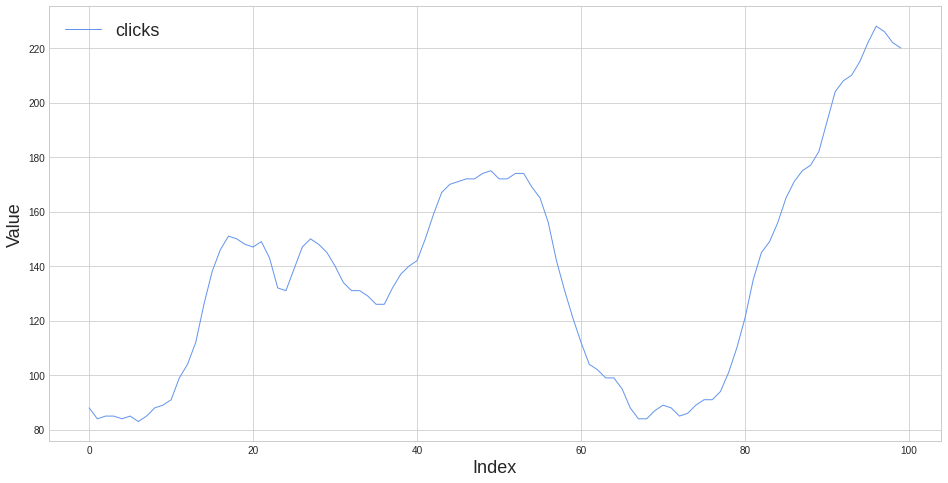

In [4]:
# plot data
plt.figure(figsize=(16,8))
plt.plot(df.index, df.loc[:,"value"], alpha=1.0, label="clicks", linewidth=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.xlabel("Index", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.show()

In [5]:
# ADF (H0: non-stationary)
def adf_stationarity_test(signal):
  result_adf = adfuller(signal, autolag="AIC")
  statistic = result_adf[0]
  p_value = result_adf[1]
  used_lag = result_adf[2]
  nobs = result_adf[3]
  critical_values = result_adf[4]
  icbest = result_adf[5]
  print("________________________________")
  print(" > ADF: Is the data stationary ?")
  print(f'ADF Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {used_lag}')
  print('Critial Values:')

  for key, value in critical_values.items():
      print(f'   {key}, {value}')  

  print(f'\nResult: The series is likely {"not " if p_value > 0.05 else ""}stationary')

In [6]:
# run stationarity test
adf_stationarity_test(df.loc[:, "value"])

________________________________
 > ADF: Is the data stationary ?
ADF Statistic: -2.4642397172033674
p-value: 0.12441935447109487
num lags: 3
Critial Values:
   1%, -3.5003788874873405
   5%, -2.8921519665075235
   10%, -2.5830997960069446

Result: The series is likely not stationary


In [7]:
# seach for d by using ndiffs from pmdarima
## Adf Test
print("ADF ndiffs: {}".format(ndiffs(df.loc[:, "value"], test='adf')))

# KPSS test
print("KPSS ndiffs: {}".format(ndiffs(df.loc[:, "value"], test='kpss')))

# PP test:
print("PP ndiffs: {}".format(ndiffs(df.loc[:, "value"], test='pp')))

ADF ndiffs: 2
KPSS ndiffs: 0
PP ndiffs: 2


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

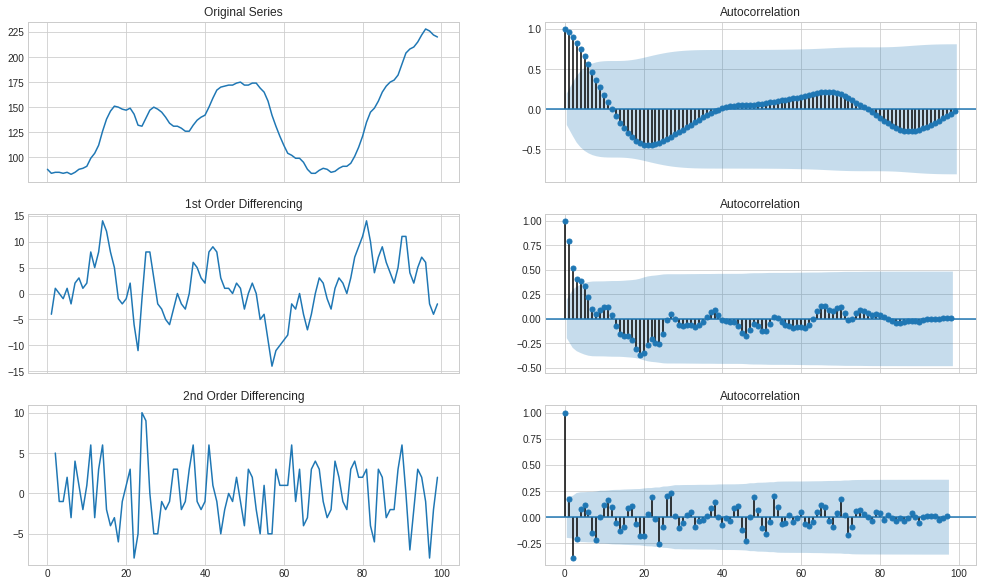

In [8]:
# plot
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(17,10))

# Original Series
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=99, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=98, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=97, ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

**So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).**

### 2.2) Finding p (order of AR term)

The next step is to identify if the model needs any AR terms. **You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.**

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

The partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of $Y$. The autoregressive equation of $Y$ is nothing but the linear regression of $Y$ with its own lags as predictors.

For Example, if $Y_{t}$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 $Y_{t-3}$ is the coefficient $\alpha_3$ of $Y_{t-3}$ in the following equation:

$Y_{t} = \alpha_{0} + \alpha_{1} Y_{t-1} + \alpha_{2} Y_{t-2} + \alpha_{3} Y_{t-3}$

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. **So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.**

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


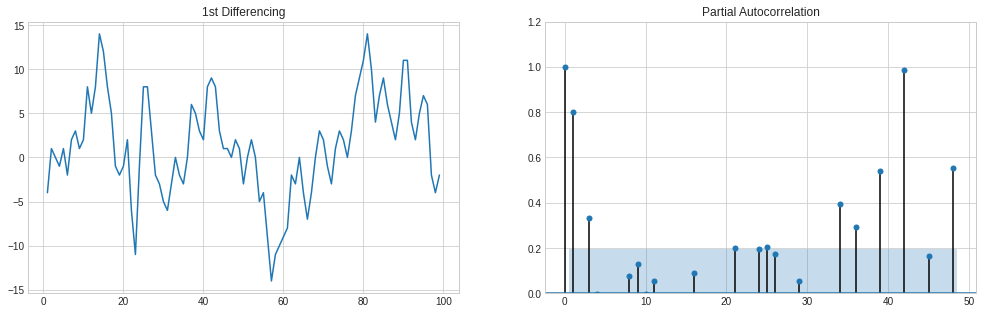

In [9]:
# we chose d = 1 (i.e. 1st differencing)
fig, axes = plt.subplots(1, 2, figsize=(17,5))

axes[0].plot(df.value.diff()) # 1st differencing here
axes[0].set_title('1st Differencing')

axes[1].set(ylim=(0,1.2))
plot_pacf(df.value.diff().dropna(), lags=48, ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). **But I am going to be conservative and tentatively fix the p as 1.**

The **Ljung-Box test** helps us check whether the lag we chose gives autocorrelations that are significantly different from zero. The **null hypothesis is that the previous lags as a whole are not correlated with the current period**. If the p-value is small enough (say 0.05), we can reject the null and **assume that the past lags have some correlation with the current period**.

In [10]:
# Ljung-Box (H0: previous lags not correlated)
def ljung_autocorr_test(signal, n_lags):
  result_ljung = acorr_ljungbox(signal, lags=n_lags)
  statistic = result_ljung[0]
  p_value = result_ljung[1]

  print("________________________________")
  print(" > Ljung-Box: Do the past lags have some correlation with the current period. ?")
  print(f'ADF Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')

  p_bool = False

  for p in p_value:
    if p >0.05:
      p_bool = True

  print(f'\nResult: The series previous lags are likely {"not " if p_bool == True else ""}correlated with the current period')

In [11]:
ljung_autocorr_test(df.value.diff().dropna(), n_lags=1)

________________________________
 > Ljung-Box: Do the past lags have some correlation with the current period. ?
ADF Statistic: [63.9619207]
p-value: [1.2684745e-15]
num lags: 1

Result: The series previous lags are likely correlated with the current period


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


### 2.3) Finding q (order of MA term)

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

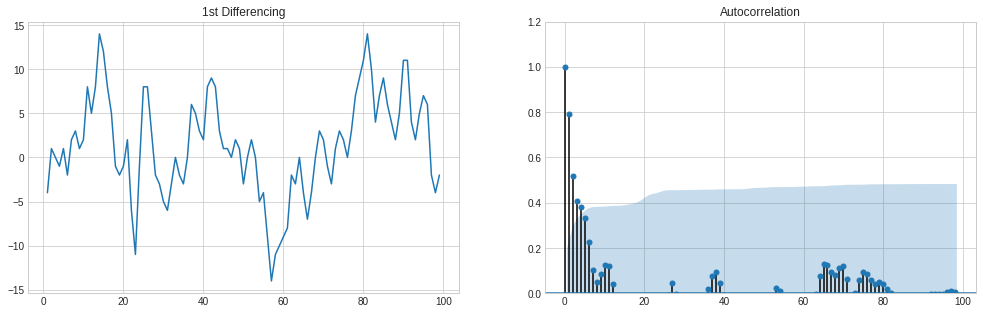

In [12]:
# we chose d = 1 (i.e. 1st differencing)
fig, axes = plt.subplots(1, 2, figsize=(17,5))

axes[0].plot(df.value.diff()) # 1st differencing here
axes[0].set_title('1st Differencing')

axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), lags=98, ax=axes[1])

plt.show()

Couple of lags are well above the significance line. **So, let’s tentatively fix q as 2.** When in doubt, go with the simpler model that sufficiently explains the Y.

## 3.) Building the ARIMA Model

Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the `ARIMA()` implementation in `statsmodels` package.

The model summary reveals a lot of information. **The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.**

### 3.1.) Foundational Steps

In [13]:
# we chose (d, p, q) = (1, 1, 2)
model = ARIMA(df.loc[:, "value"], order=(1, 1, 2))
model_fit = model.fit(display=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Wed, 18 Aug 2021   AIC                            517.579
Time:                        07:23:21   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.


In [14]:
# we now choose (d, p, q) = (1, 1, 1)
model = ARIMA(df.loc[:, "value"], order=(1, 1, 1))
model_fit = model.fit(display=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Wed, 18 Aug 2021   AIC                            515.579
Time:                        07:23:21   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

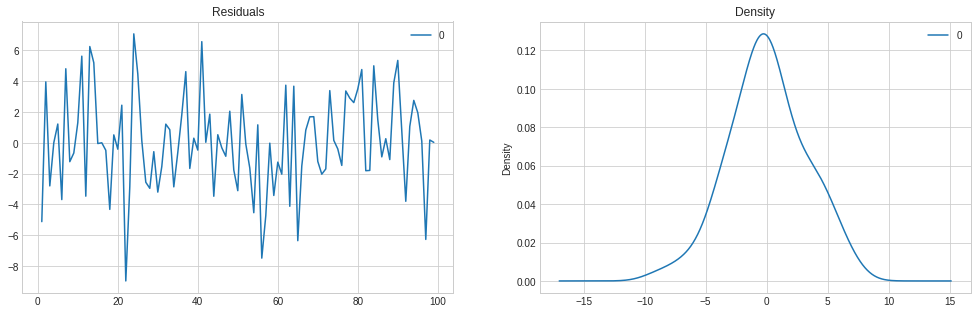

In [15]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using `plot_predict()`.

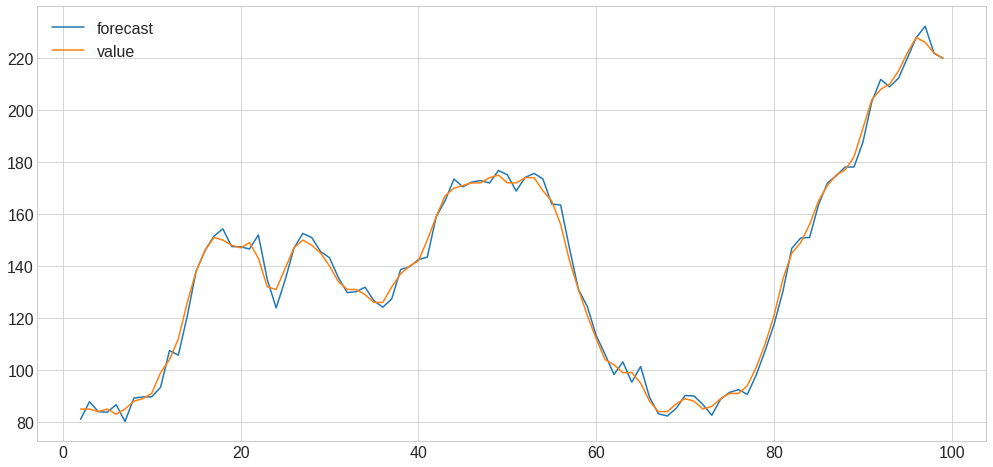

In [16]:
# Actual vs Fitted
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,8))
model_fit.plot_predict(dynamic=False, ax=ax)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.legend(fontsize=16)
plt.show()

When you set dynamic=False the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.



### 3.2.) Optimal ARIMA Model (manually) via Out-of-Time Cross Validation

In Out-of-Time cross-validation, you **take few steps back in time and forecast into the future to as many steps you took back**. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, **you need to create the training and testing dataset** by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why not sample the training data randomly?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.



In [17]:
# Create Training and Test
train = df.loc[:, "value"].iloc[:85]
test = df.loc[:, "value"].iloc[85:]

In [18]:
# Build Model
# model = ARIMA(train, order=(d, p, q)) 
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

In [19]:
# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

In [20]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

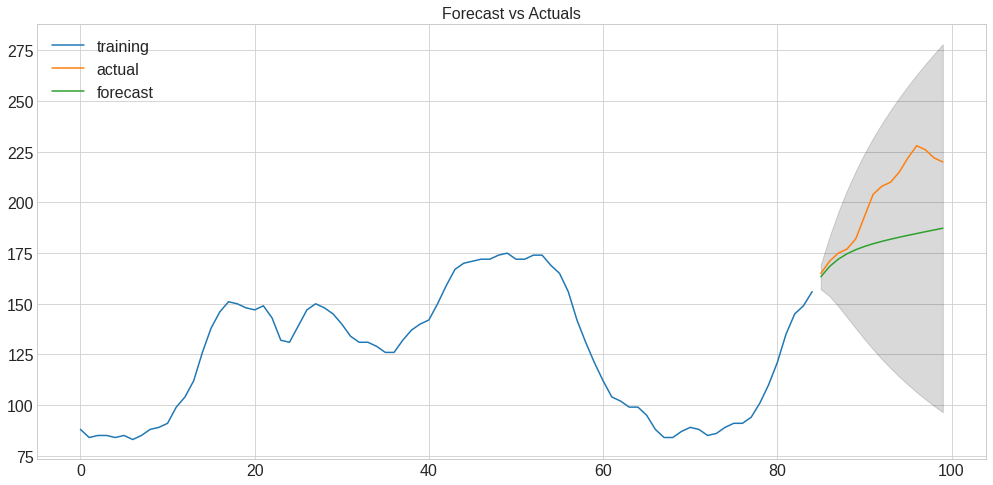

In [21]:
# Plot
plt.figure(figsize=(17,8))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

**But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve.** So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is **set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.**

While doing this, I **keep an eye on the P values of the AR and MA terms in the model summary.** They should be as close to zero, ideally, less than 0.05.

In [22]:
# Build Model (d, p, q)
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Wed, 18 Aug 2021   AIC                            440.497
Time:                        07:23:22   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.564      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [23]:
# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

In [24]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

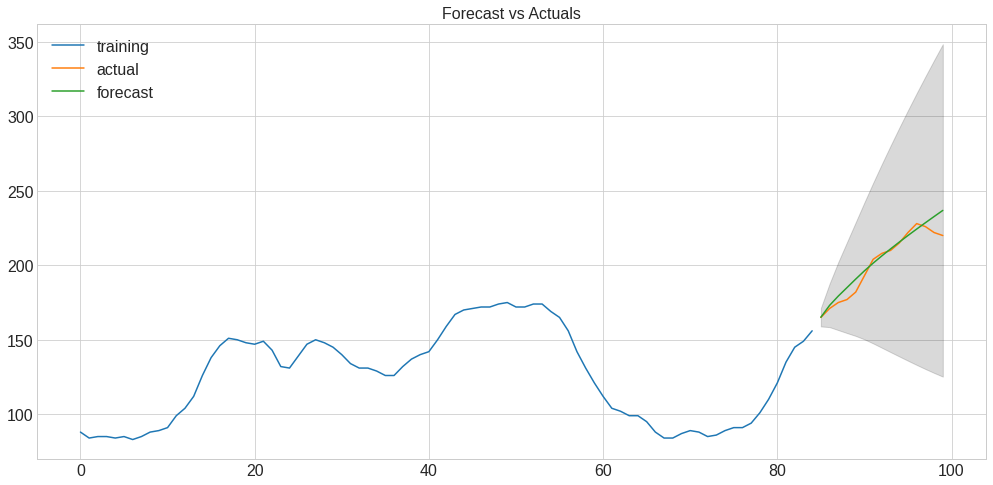

In [25]:
# Plot
plt.figure(figsize=(17,8))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

**Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year**.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

### 3.3.) Auto ARIMA for (d, p, q)

Like R’s popular `auto.arima()` function, the `pmdarima` package provides `auto_arima()` with similar functionality.

`auto_arima()` uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [26]:
# Build model automatically finding (d, p, q)
model = pm.auto_arima(df.loc[:, "value"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

## 4.) Accuracy Metrics for Time Series Forecasts

The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Lag 1 Autocorrelation of Error (ACF1)
- Correlation between the Actual and the Forecast (corr)
- Min-Max Error (minmax)

Typically, if you are **comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used**.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [27]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):

  # Mean Absolute Percentage Error (MAPE)
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))

  # Mean Error (ME)
  me = np.mean(forecast - actual)       

  # Mean Absolute Error (MAE)
  mae = np.mean(np.abs(forecast - actual)) 

  # Mean Percentage Error (MPE)
  mpe = np.mean((forecast - actual)/actual) 

  # Root Mean Squared Error (RMSE)
  rmse = np.mean((forecast - actual)**2)**.5

  # Correlation between the Actual and the Forecast (corr)
  corr = np.corrcoef(forecast, actual)[0,1] 

  # Lag 1 Autocorrelation of Error (ACF1)
  acf1 = acf(fc-test)[1]       

  # Min-Max Error (minmax)
  mins = np.amin(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)      
  
  # output
  return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [28]:
forecast_accuracy(fc, test.values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


{'acf1': 0.5105507384159967,
 'corr': 0.967457656357808,
 'mae': 4.5483201731670855,
 'mape': 0.022501304018041467,
 'me': 3.2307775752957713,
 'minmax': 0.021631539372567676,
 'mpe': 0.016420976317557737,
 'rmse': 6.373234652385167}

Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 (85 training; 15 test) observations.

## 5.) Residual Plot Interpretation

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

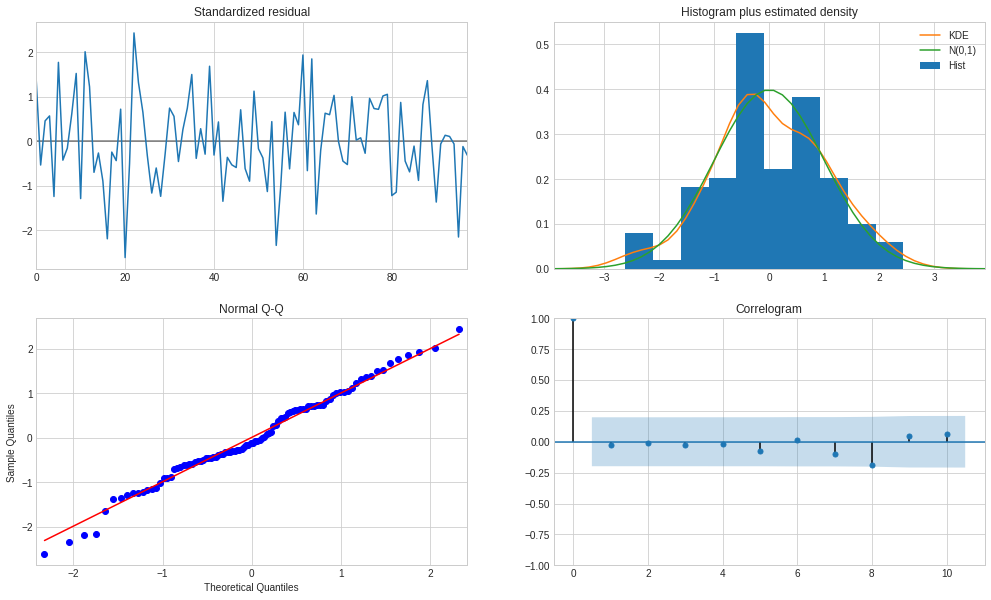

In [29]:
model.plot_diagnostics(figsize=(17,10))
plt.show()

## 6.) Final ARIMA Forecast

In [30]:
# Forecast
n_periods = 7
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

In [31]:
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

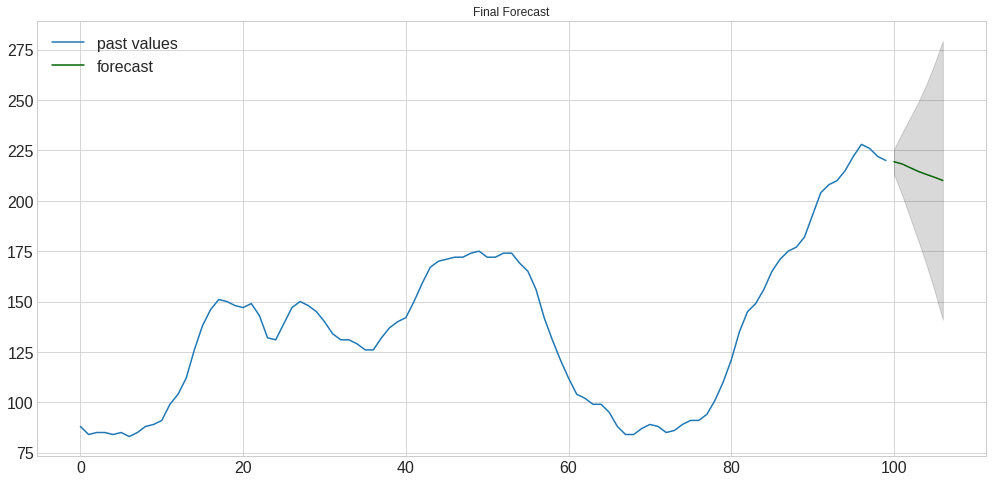

In [32]:
# Plot
plt.figure(figsize=(17,8))
plt.plot(df.value, label='past values')
plt.plot(fc_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Final Forecast")
plt.show()